<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import warnings
from tqdm import tqdm_notebook
import ipywidgets
import time

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set()
seed = 42
# data_path = './data/competition_data'

**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/bb11ace54b1a465e91b8c3f46a840ce0)**

# Exploratory Data Analysis and Metric

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [4]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [5]:
# Removing sentences which consists just of digits
train_df = train_df.drop(train_df[train_df.sentence.str.isdigit()].index, axis=0)

In [6]:
# Removing duplicate sentences  
target = train_df.language
train_df = pd.DataFrame.drop_duplicates(train_df.drop('language', axis=1))
traget = target[train_df.index]
train_df = pd.concat([train_df, traget], axis=1)

In [7]:
# Removing duplicate words in each sentence of train and test tatasets
train_df.sentence = train_df.sentence.str.split().apply(lambda x: ' '.join(OrderedDict.fromkeys(x).keys()))
test_df.sentence = test_df.sentence.str.split().apply(lambda x: ' '.join(OrderedDict.fromkeys(x).keys()))

<AxesSubplot:>

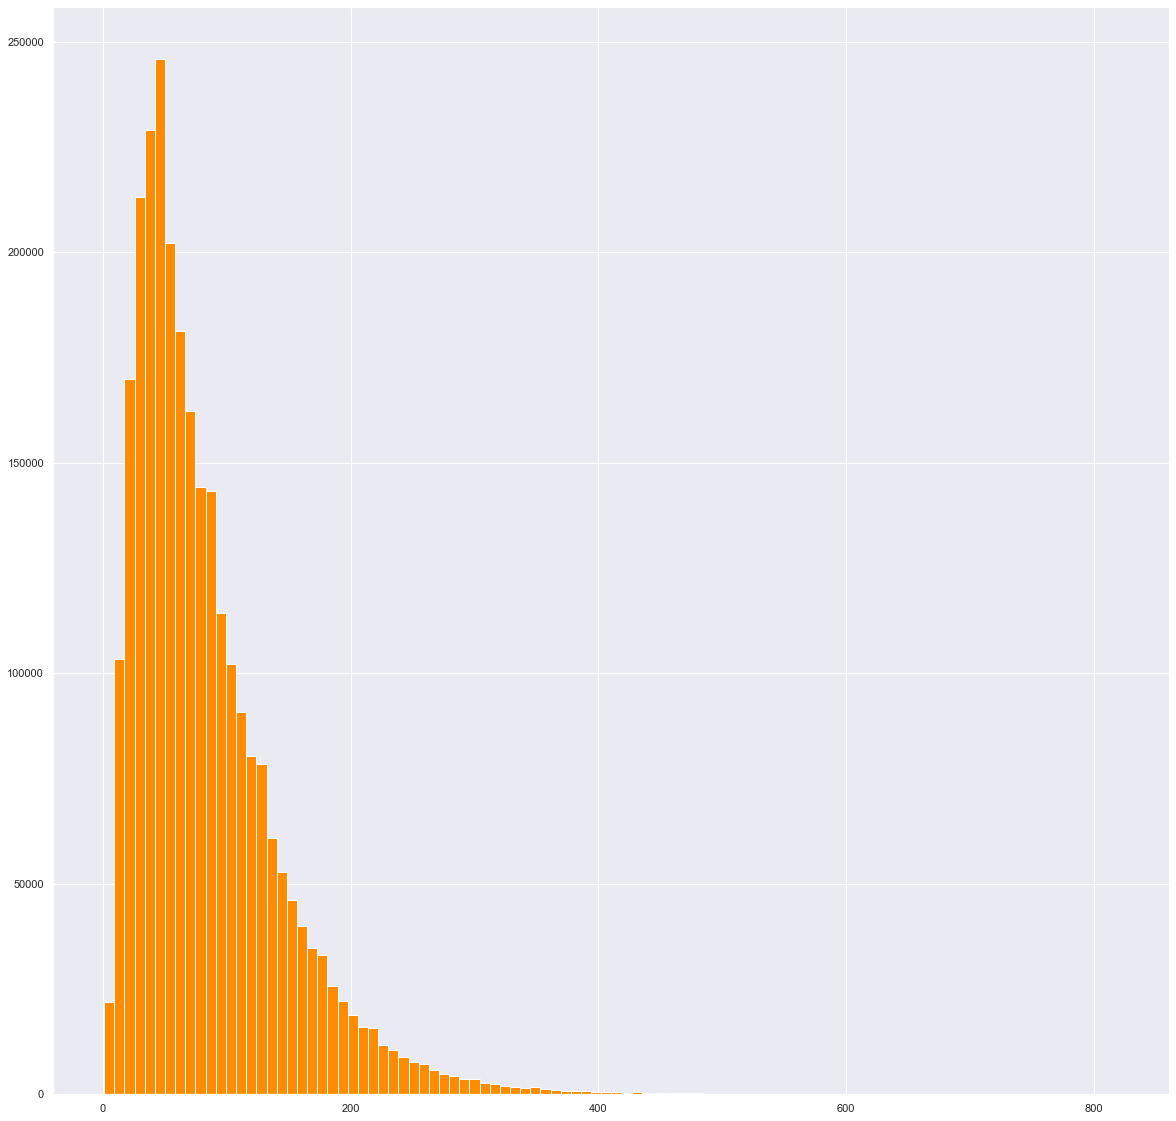

In [8]:
plt.figure(figsize=(20,20))
train_df.sentence.str.len().hist(bins=100, color='darkorange')

In [9]:
train_df.sentence.str.len().median()

67.0

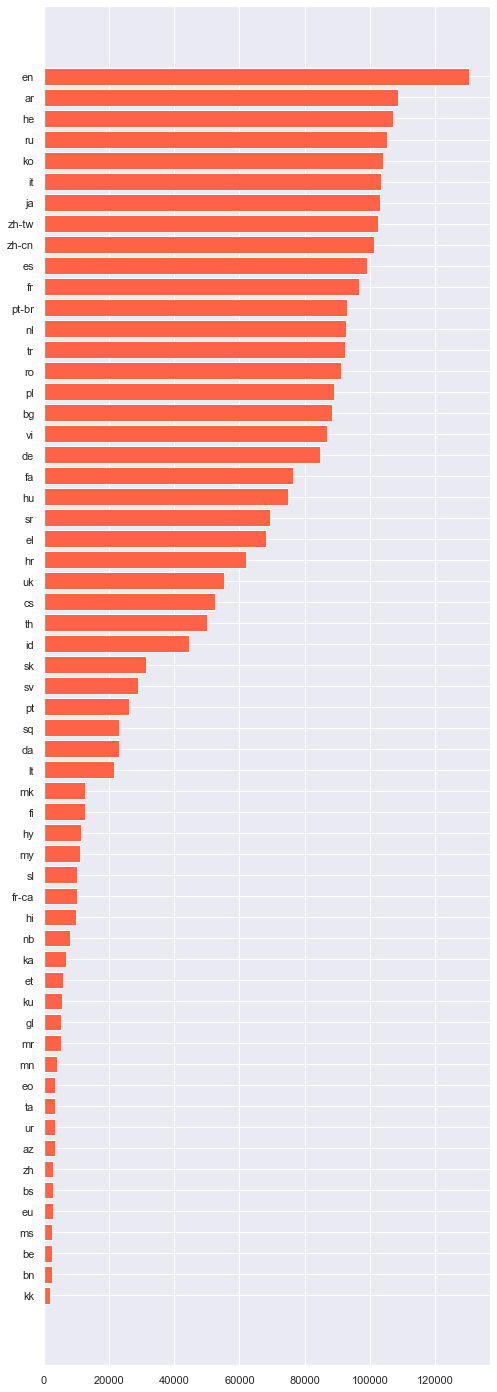

In [10]:
fig, ax = plt.subplots(figsize=(8,25))
lang_count = (train_df.language.value_counts().to_frame().reset_index())
ax.barh(lang_count['index'], lang_count['language'], color='tomato')
ax.invert_yaxis()

In [11]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
0,en,130315
58,kk,2015


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{130315}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2015}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Model

In [12]:
# Processed datasets
train_df.shape, test_df.shape

((2738550, 2), (2784634, 2))

In [13]:
# Encode target labels
label_encoder = LabelEncoder()
train_df.language = label_encoder.fit_transform(train_df.values[:, 1])

In [23]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=0.95, min_df=1)),
    ('model', SGDClassifier(random_state=seed, loss='log', n_jobs=-1, alpha=1e-8))
])

In [24]:
# Testing balanced accuracy splitting our train dataset on batches and choosing optimal parameters

def batch_parts_training(dataset, batch_size):
    for i in range(dataset.shape[0] // batch_size):
        index = np.random.choice(dataset.index.values, batch_size, replace=False)
        dataset_batch = dataset.loc[index]
        x_train, x_test, y_train, y_test = train_test_split(dataset_batch.values[:,0], 
                                                            dataset_batch.language, test_size=0.2, random_state=seed)
        pipe.fit(x_train, y_train)
        y_pred = pipe.predict(x_test)
        print(balanced_accuracy_score(y_test, y_pred))  
        dataset = dataset.drop(index, axis=0)
        
batch_parts_training(train_df, 450000)

In [39]:
# Train and target values
x = train_df.values[:, 0]
y = train_df.language

In [40]:
%%time
pipe.fit(x, y)
predictions = pipe.predict(x)
balanced_accuracy_score(y, predictions)

0.9783693075137212

# Submit

In [41]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [42]:
test_df['language'] = label_encoder.classes_[submit_predictions]
test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,zh-tw


In [43]:
test_df[['index', 'language']].to_csv('sample_submission.csv', index=False)

# Homework

- выбить хороший score на private leaderboard'е (8 баллов)
- совет: поищите ошибки в train-части датасета